In [1]:
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [3]:
import fastai
dir(fastai.vision.widgets)

['AdaptiveAvgPool',
 'AdaptiveConcatPool1d',
 'AdaptiveConcatPool2d',
 'AddMaskCodes',
 'ArrayBase',
 'ArrayImage',
 'ArrayImageBW',
 'ArrayImageBase',
 'ArrayMask',
 'AttrDict',
 'AttrGetter',
 'AutoInit',
 'AvgPool',
 'BBoxLabeler',
 'BCELossFlat',
 'BCEWithLogitsLossFlat',
 'BaseLoss',
 'BatchNorm',
 'BatchNorm1dFlat',
 'BatchSampler',
 'Box',
 'BuiltinFunctionType',
 'BuiltinMethodType',
 'Button',
 'BypassNewMeta',
 'ByteTensor',
 'Cat',
 'Categorize',
 'Category',
 'CategoryBlock',
 'CategoryMap',
 'Checkbox',
 'Chunks',
 'ColReader',
 'ColSplitter',
 'CollBase',
 'Config',
 'ContextManagers',
 'ConvLayer',
 'Counter',
 'CrossEntropyLossFlat',
 'DataBlock',
 'DataLoader',
 'DataLoaders',
 'Datasets',
 'Debugger',
 'DiceLoss',
 'DispatchReg',
 'DisplayedTransform',
 'DoubleTensor',
 'Dropdown',
 'Embedding',
 'EncodedMultiCategorize',
 'EndSplitter',
 'Enum',
 'EventTimer',
 'ExceptionExpected',
 'ExceptionsHTTP',
 'F',
 'FileGetter',
 'FileSplitter',
 'FileUpload',
 'FilteredBase

In [4]:
key = '0fdfc105be0b4792ae63649c52fd920a'

In [5]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [6]:
results = search_images_bing(key, 'grizzl bear')
ims = results.attrgot('contentUrl')
len(ims)

HTTPError: 401 Client Error: PermissionDenied for url: https://api.bing.microsoft.com/v7.0/images/search?q=grizzl+bear&count=150&min_height=128&min_width=128

In [7]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

im = Image.open(dest)
im.to_thumb(128, 128)

NameError: name 'ims' is not defined

In [10]:
bear_types = 'grizzly', 'black', 'teddy'
path = Path('bears')

if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [11]:
fns = get_image_files(path)

In [12]:
fns

(#393) [Path('bears/grizzly/00000077.jpg'),Path('bears/grizzly/00000098.jpg'),Path('bears/grizzly/00000119.jpg'),Path('bears/grizzly/00000122.png'),Path('bears/grizzly/00000004.jpg'),Path('bears/grizzly/00000021.jpg'),Path('bears/grizzly/00000043.jpg'),Path('bears/grizzly/00000093.jpg'),Path('bears/grizzly/00000134.jpg'),Path('bears/grizzly/00000059.jpg')...]

In [13]:
failed = verify_images(fns)

In [14]:
failed.map(Path.unlink)

(#0) []

In [15]:
??verify_images

Signature: verify_images(fns)
Source:   
def verify_images(fns):
    "Find images in `fns` that can't be opened"
    return L(fns[i] for i,o in enumerate(parallel(verify_image, fns)) if not o)
File:      ~/anaconda3/envs/fastai/lib/python3.8/site-packages/fastai/vision/utils.py
Type:      function


In [16]:
?verify_images

Signature: verify_images(fns)
Docstring: Find images in `fns` that can't be opened
File:      ~/anaconda3/envs/fastai/lib/python3.8/site-packages/fastai/vision/utils.py
Type:      function


In [17]:
doc(verify_images)

verify_images [source] verify_images ( fns ) 
 
 Find images in fns that can't be opened 
 Show in docs

In [18]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)

In [19]:
dls = bears.dataloaders(path)

In [20]:
path

Path('bears')

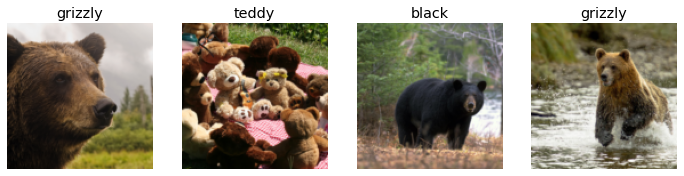

In [21]:
dls.valid.show_batch(max_n=4, nrows=1)

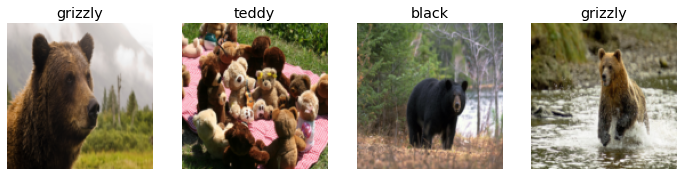

In [22]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

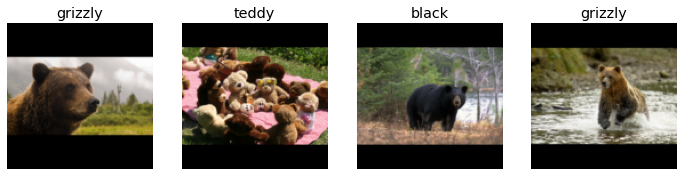

In [23]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

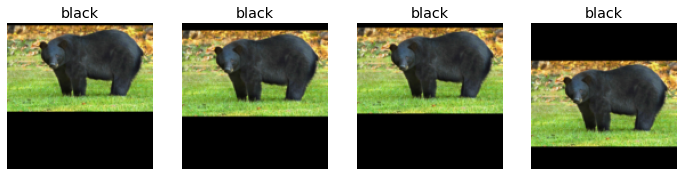

In [24]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dlfs = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

/home/pytorch/anaconda3/envs/fastai/lib/python3.8/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630839582/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


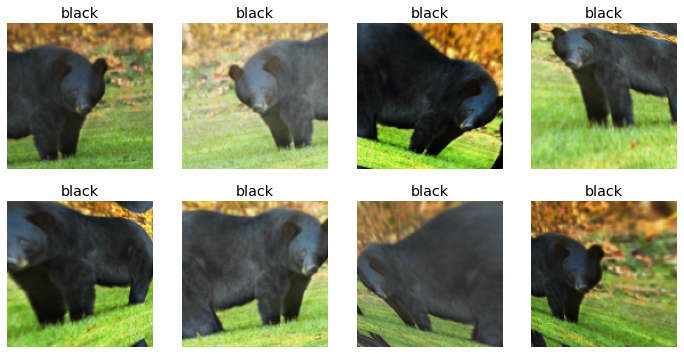

In [25]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [26]:
bears = bears.new(item_tfms=RandomResizedCrop(224, min_scale=0.5), 
                 batch_tfms=aug_transforms())
dls = bears.dataloaders(path)
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.500756,0.166935,0.064103,00:23


epoch,train_loss,valid_loss,error_rate,time
0,0.288104,0.058911,0.025641,00:29
1,0.208004,0.075563,0.012821,00:29
2,0.156723,0.089842,0.012821,00:30
3,0.137756,0.090013,0.012821,00:31


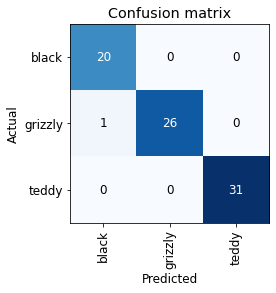

In [27]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

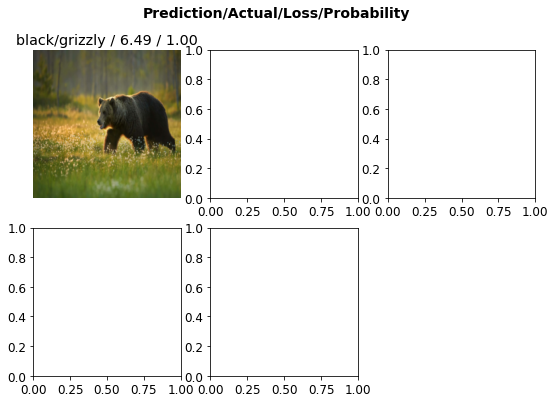

In [28]:
interp.plot_top_losses(5, nrows=2)

In [29]:
cleaner = ImageClassifierCleaner(learn)

In [30]:
cleaner

In [31]:
# for idx in cleaner.delete():
#     cleaner.fns[idx].unlink()

In [32]:
# for idx, cat in cleaner.change():
#     shutil.move(str(cleaner.fns[idx]), path/cat)

In [33]:
len(cleaner.fns)

30

In [34]:
cleaner.fns

(#30) [Path('bears/black/00000102.jpg'),Path('bears/black/00000013.jpg'),Path('bears/black/00000145.jpg'),Path('bears/black/00000107.jpg'),Path('bears/black/00000032.jpg'),Path('bears/black/00000062.png'),Path('bears/black/00000060.JPG'),Path('bears/black/00000007.jpg'),Path('bears/black/00000051.jpg'),Path('bears/black/00000076.jpg')...]

In [35]:
cleaner.delete()

(#0) []

In [36]:
cleaner.change()

(#0) []

In [37]:
path

Path('bears')

In [38]:
dir(Path)

['__bytes__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__fspath__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rtruediv__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__truediv__',
 '_accessor',
 '_cached_cparts',
 '_closed',
 '_cparts',
 '_drv',
 '_format_parsed_parts',
 '_from_parsed_parts',
 '_from_parts',
 '_hash',
 '_init',
 '_make_child',
 '_make_child_relpath',
 '_opener',
 '_parse_args',
 '_parts',
 '_pparts',
 '_raise_closed',
 '_raw_open',
 '_root',
 '_str',
 'absolute',
 'anchor',
 'as_posix',
 'as_uri',
 'chmod',
 'cwd',
 'delete',
 'drive',
 'exists',
 'expanduser',
 'glob',
 'group',
 'home',
 'is_absolute',
 'is_block_device',
 'is_char_device',
 'is_dir',
 'is_fifo',
 'is_file',
 'is_mount',
 'is_reserved',
 'is

In [39]:
learn.export()

In [40]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [41]:
learn_inf = load_learner(path / 'export.pkl')

learn_inf.predict('images/grizzly.jpg')

('grizzly', tensor(1), tensor([3.5449e-05, 9.9996e-01, 5.6098e-07]))

In [42]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

In [43]:
dir(learn.dls)

['_DataLoader__idxs',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_tfms',
 '_after_item',
 '_call',
 '_component_attr_filter',
 '_component_attr_filter',
 '_component_attr_filter',
 '_dbunch_type',
 '_dbunch_type',
 '_decode_batch',
 '_default',
 '_default',
 '_default',
 '_device',
 '_dir',
 '_dir',
 '_dir',
 '_dl_type',
 '_dl_type',
 '_do_call',
 '_docs',
 '_docs',
 '_get',
 '_is_showable',
 '_methods',
 '_n_inp',
 '_name',
 '_new',
 '_new',
 '_noop_methods',
 '_one_pass',
 '_pre_show_batch',
 '_repr_pretty_',
 '_retain_dl',
 '_set',
 '_types',
 'add',
 'add_na',
 'add_tfms',
 'after_batch',


In [44]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [46]:
img = PILImage.create(btn_upload.data[-1])

In [47]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl:display(img.to_thumb(128, 128))
out_pl

Output()

In [48]:
pred, pred_idx, probs = learn_inf.predict(img)

In [49]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: teddy; Probability: 1.0000')

In [50]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [51]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128, 128))
    pred, pred_idx, probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [52]:
VBox([widgets.Label('Select your bear!'),
     btn_upload, btn_run, out_pl, lbl_pred])